In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

This is a dataset that consist about marketing campaign on website and its consumer profile. So we are going to anaylize it and doing user segmentation by using RFM analaysis, also we are convert it into a dashboard to easily make this dataset useful to many stakeholder (especially marketing when they are going to make different campaign)

In [2]:
data = pd.read_excel('Marketing/marketing_data.xlsx')
data

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,NumWebPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2
0,1826,1970,Graduation,Divorced,"$84,835.00",6/16/14,0,189,104,379,111,4,1,0,0,0,0,0
1,1,1961,Graduation,Single,"$57,091.00",6/15/14,0,464,5,64,7,7,5,0,0,0,0,1
2,10476,1958,Graduation,Married,"$67,267.00",5/13/14,0,134,11,59,15,3,2,0,0,0,0,0
3,1386,1967,Graduation,Together,"$32,474.00",5/11/14,0,10,0,1,0,1,7,0,0,0,0,0
4,5371,1989,Graduation,Single,"$21,474.00",4/8/14,0,6,16,24,11,3,7,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,"$66,476.00",3/7/13,99,372,18,126,47,5,4,0,0,0,0,0
2236,5263,1977,2n Cycle,Married,"$31,056.00",1/22/13,99,5,10,13,3,1,8,0,0,0,0,0
2237,22,1976,Graduation,Divorced,"$46,310.00",12/3/12,99,185,2,88,15,6,8,0,0,0,0,0
2238,528,1978,Graduation,Married,"$65,819.00",11/29/12,99,267,38,701,149,5,3,0,0,0,0,0


Explanation
- Recency: number of days since customer last purchase
- MntWines/Fruits/etc: amount spent on its product for the last 1 year
- NumWebPurchases: Number of purchases made through the company's website in the last 1 year
- NumWebVisitMonth: Number of visit to company's website in the last 1 year
- AcceptedCmp1/2/etc: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise 

### Filling NaN Value

In [3]:
data.isna().sum().sort_values(ascending=False)

 Income              24
ID                    0
MntFishProducts       0
AcceptedCmp1          0
AcceptedCmp5          0
AcceptedCmp4          0
AcceptedCmp3          0
NumWebVisitsMonth     0
NumWebPurchases       0
MntMeatProducts       0
Year_Birth            0
MntFruits             0
MntWines              0
Recency               0
Dt_Customer           0
Marital_Status        0
Education             0
AcceptedCmp2          0
dtype: int64

What we see in here that there are many IDs that their income is NaN and it is not a problem because probably they are not graduated yet/they still finding for a job/they are not willing to fill their income data. Let see its distribution!

<AxesSubplot:xlabel='Education', ylabel='count'>

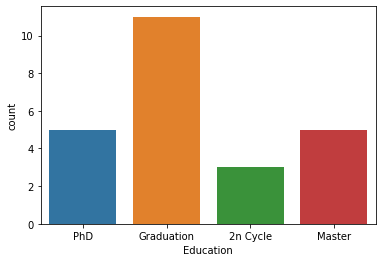

In [4]:
#Finding NaN Values
nan_income = data[data[' Income '] != data[ ' Income ']]
sns.countplot(data=nan_income, x='Education')

We see in here that the NaN income's ID is ranging from 2n Cycle - PhD, so we cannot assume that they are not only have not graduated yet, but can be from other reasoning.

So we decided to fill NaN income data with '0'

In [5]:
data[' Income '].fillna('$0', inplace=True)

### Cleaning Data and Changing Dtypes

In [6]:
#Cleaning $ and change datatypes in to int
data[' Income ']  = data[' Income '].replace(r'[A-Za-z$,\s]', '', regex=True)
data[' Income ']  = data[' Income '].replace(r'[.][0]{2}', '', regex=True)

In [7]:
#Changing Dtypes
data[' Income ']  = data[' Income '].astype(str).astype('int64')
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

### Profile Classification

Since we know that there are many profile variables in ther (year of birth, income, etc.), we can make a classification based on particular country standard (for now we are following US standard)

**Age Classification**

We need to know what is the range of age for all IDs

In [8]:
data.Year_Birth.sort_values()

513     1893
827     1899
2233    1900
2171    1940
1740    1941
        ... 
697     1995
964     1995
1468    1995
1824    1996
562     1996
Name: Year_Birth, Length: 2240, dtype: int64

Age Classification (assumption current year is 2015)
- 1975-2000 : Young Adults
- 1955-1974 : Middle-aged
- 1893-1954 : Old 

In [9]:
#Classifying Ages based on US data
age_class = []
for x in data['Year_Birth']:
    if x > 1975:
        age_class.append('Young Adults')
    elif x<1975 and x>=1955:
        age_class.append('Middle-aged')
    else:
        age_class.append('Old')

**Income Classification**

We are following US standard for income classification

In [10]:
#Creating Income Classification
income_class = []
for x in data[' Income ']:
    if x < 52200:
        income_class.append('Low Income')
    elif x >= 15600 and x < 52200:
        income_class.append('Middle Income')
    else:
        income_class.append('Upper Income')

# RFM Analysis

As we know from the data given, we can do profile geography distribution so we can map what kind of profile that join particular campaign, spending for certain products, and how many times they're visiting the website.

However, we are not only can map profile based on their geography data, but we can do it by looking at their value and behavior. We call it **"RFM Analysis"**, by looking at their:
1. Recency (when the last time they are visiting the website)
2. Frequency (how many time in avg. they are visiting the website in a month)
3. Monetization (how much money they willing to spend in a month)

For **RFM Analysis**, we can do it by using two approach to find out users segment in our population:

1. Manual (plot distribution)
2. Kmeans 

After we are doing it, we can came up with several profile segmentations that can be used for marketing teams so in the end they are able to capture which segments that potential to be targeted for particular type of campaign.

### Data Creation for Recency, Frequency, Monetization ###

In [11]:
#Checking overall variables related to RFM
col_rfm = ['ID', 'Recency', 'NumWebPurchases','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts']
data_rfm = data[col_rfm]

#Creating Monetization Column from adding all products spending
data_rfm = (data_rfm.assign(Monetization = data_rfm['MntWines'] + data_rfm[
    'MntFruits'] + data_rfm['MntMeatProducts'] + data_rfm['MntFishProducts']).rename({'NumWebPurchases':'Frequency'}, axis=1))
data_rfm

,ID,Recency,Frequency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,Monetization
0,1826,0,4,189,104,379,111,783
1,1,0,7,464,5,64,7,540
2,10476,0,3,134,11,59,15,219
3,1386,0,1,10,0,1,0,11
4,5371,0,3,6,16,24,11,57
...,...,...,...,...,...,...,...,...
2235,10142,99,5,372,18,126,47,563
2236,5263,99,1,5,10,13,3,31
2237,22,99,6,185,2,88,15,290
2238,528,99,5,267,38,701,149,1155


In [12]:
col_rfm = ['ID', 'Recency', 'Frequency', 'Monetization']
data_rfm = data_rfm[col_rfm]
data_rfm

,ID,Recency,Frequency,Monetization
0,1826,0,4,783
1,1,0,7,540
2,10476,0,3,219
3,1386,0,1,11
4,5371,0,3,57
...,...,...,...,...
2235,10142,99,5,563
2236,5263,99,1,31
2237,22,99,6,290
2238,528,99,5,1155


## 1st Approach: Manual Analysis

We are going to do manual analysis for RFM by looking at its distribution and pattern

First we are giving them scoring based on the percentile for each R F M. It will be used for later, first we set the average threshold so we can decide the segmentation for this RFM approach.

In [13]:
#Creating RFM Scoring for Recency
data_rfm["R_score"] = pd.cut(data_rfm["Recency"], 
                                       bins=[-1, 
                                         np.percentile(data_rfm["Recency"], 25), 
                                             np.percentile(data_rfm["Recency"], 50), 
                                             np.percentile(data_rfm["Recency"], 75), 
                                             data_rfm["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

<ipython-input-13-5f608c177485>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfm["R_score"] = pd.cut(data_rfm["Recency"],


In [14]:
#Creating RFM Scoring for Frequency
data_rfm["F_score"] = pd.cut(data_rfm["Frequency"], 
                                       bins=[-1, 
                                         np.percentile(data_rfm["Frequency"], 25), 
                                             np.percentile(data_rfm["Frequency"], 50), 
                                             np.percentile(data_rfm["Frequency"], 75), 
                                             data_rfm["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

<ipython-input-14-22998c6d986d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfm["F_score"] = pd.cut(data_rfm["Frequency"],


In [15]:
#Creating RFM Scoring for Monetization
data_rfm["M_score"] = pd.cut(data_rfm["Monetization"], 
                                       bins=[-1, 
                                         np.percentile(data_rfm["Monetization"], 25), 
                                             np.percentile(data_rfm["Monetization"], 50), 
                                             np.percentile(data_rfm["Monetization"], 75), 
                                             data_rfm["Monetization"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

<ipython-input-15-d7028ad3bbe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfm["M_score"] = pd.cut(data_rfm["Monetization"],


In [16]:
data_rfm

,ID,Recency,Frequency,Monetization,R_score,F_score,M_score
0,1826,0,4,783,4,2,3
1,1,0,7,540,4,4,3
2,10476,0,3,219,4,2,2
3,1386,0,1,11,4,1,1
4,5371,0,3,57,4,2,2
...,...,...,...,...,...,...,...
2235,10142,99,5,563,1,3,3
2236,5263,99,1,31,1,1,1
2237,22,99,6,290,1,3,2
2238,528,99,5,1155,1,3,4


We need to total their RFM scores

In [17]:
data_rfm['RFM_total'] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']

### 1st approach = Manual

To start it off, we need to see how the distribution of total RFM_score to measure what is the threshold we are going to put

In [18]:
data_rfm.groupby('RFM_total').agg({'Recency':['min', 'median', 'max'],
                                  'Frequency':['min', 'median', 'max'],
                                  'Monetization':['min', 'median', 'max']})

Recency            Frequency            Monetization              
              min median max       min median max          min  median   max
RFM_total                                                                   
3              75   86.0  99         0      1   2            4    30.0    50
4              50   71.0  99         0      1   3            3    39.0   256
5              25   49.0  99         0      2   4            7    41.0   830
6               0   35.5  99         0      2   6            5    58.5  1605
7               0   53.0  99         0      4  23           24   292.0  1964
8               0   58.0  99         0      4  11           55   674.0  2145
9               0   50.0  99         0      6  27           12   862.5  2285
10              0   30.0  74         3      6  11          328   916.0  2343
11              0   17.0  48         5      7  11          331  1026.5  2213
12              0   12.0  24         7      8  11          951  1197.0  2071

We are going to classify our segment into two sides, by choosing the threshold number for each R,F,M, by looking from its median distribution. We will come up with MVP customer which has the best part of R,F,M. Our **MVP customer** are those with below classification
- Recency : its median threshold divided into those who below 30 days and above 30 days
- Frequency (visitsMonthly) : As we can see the distribution threshold divided into those >6 times and <=6 times
- Spending Ratio : we see in here that we are going to classify from people who are willing to spend median above 862 and below it

In [19]:
#Percentage people who are MVP
count_mvp = data_rfm.query("Recency <= 30 and Frequency > 6 and Monetization > 862 ")['ID'].count().sum()
percentage = count_mvp/(data_rfm['ID'].count().sum())*100
print(f'Total number of our MVP ID is {count_mvp} and percentation from its total population is {percentage}%' )

Total number of our MVP ID is 64 and percentation from its total population is 2.857142857142857%


### Segmenting

In [20]:
#Mapping Data RFM Classification
data_rfm['r_threshold'] = (data_rfm['Recency'] <= 30)
data_rfm['f_threshold'] = (data_rfm['Frequency'] > 6)
data_rfm['m_threshold'] = (data_rfm['Monetization'] > 862)
data_rfm.groupby(['r_threshold', 'f_threshold', 'm_threshold']).count()['ID']

r_threshold  f_threshold  m_threshold
False        False        False          947
                          True           286
             True         False          144
                          True           139
True         False        False          457
                          True           127
             True         False           76
                          True            64
Name: ID, dtype: int64

Way to do the Segmenting

1. **MVP Customer (R<=30, F>6, M>862) @64** : Customer who transacted recently, do so often and spend more than other customers.

2. **Loyal User Less Spend (R<=30, F>6, M<862) @76** : Customer who actively engage with the campaign and website, but reluctant to spend more with they money

3. **Recently Active Not Frequent (R<=30, F<=6) @584** : Customer who active recently (can be just signed up), but they rarely order or open the website (regardless of their spending stlye)

4. **Churned Customer (R>30, F>6) @283** : Its been a long time since their last transaction, however they used to frequently active

5. **Low Activity High Values (R>30, F<=6, M>=862) @572** : Customers that not been really active and not that frequent, but their spending is really big

6. **Low Activity Low Values (R>30, F<=6) @947** : Not really a valuable customers

Now we are going to applying new segmentation to current population

In [22]:
def rfmAnalyze(row):
    if row['Recency']<=30 and row['Frequency']>6 and row['Monetization']>=862:
        return 'MVP Customer'
    elif row['Recency']<=30 and row['Frequency']>6 and row['Monetization']<862:
        return 'Loyal User Less Spend'
    elif row['Recency']<=30 and row['Frequency']<=6:
        return 'Recently Active Not Frequent'
    elif row['Recency']>30 and row['Frequency']>6:
        return 'Churned Customer'
    elif row['Recency']>30 and row['Frequency']<=6 and row['Monetization']>=862:
        return 'Low Activity High Values'
    else:
        return 'Low Activity Low Values'

data_rfm_1 = data_rfm
data_rfm_1['rfm_class'] = data_rfm.apply(lambda x: rfmAnalyze(x), axis=1)
data_rfm_1

,ID,Recency,Frequency,Monetization,R_score,F_score,M_score,RFM_total,r_threshold,f_threshold,m_threshold,rfm_class
0,1826,0,4,783,4,2,3,9,True,False,False,Recently Active Not Frequent
1,1,0,7,540,4,4,3,11,True,True,False,Loyal User Less Spend
2,10476,0,3,219,4,2,2,8,True,False,False,Recently Active Not Frequent
3,1386,0,1,11,4,1,1,6,True,False,False,Recently Active Not Frequent
4,5371,0,3,57,4,2,2,8,True,False,False,Recently Active Not Frequent
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,99,5,563,1,3,3,7,False,False,False,Low Activity Low Values
2236,5263,99,1,31,1,1,1,3,False,False,False,Low Activity Low Values
2237,22,99,6,290,1,3,2,6,False,False,False,Low Activity Low Values
2238,528,99,5,1155,1,3,4,8,False,False,True,Low Activity High Values


## 2nd Approach: K-means Segmentation

We are going to use the current dataset "data_rfm" and its particular columns (only R, F, M)

In [23]:
rfm_2 = data_rfm.loc[:, 'ID':'Monetization']
rfm_2

,ID,Recency,Frequency,Monetization
0,1826,0,4,783
1,1,0,7,540
2,10476,0,3,219
3,1386,0,1,11
4,5371,0,3,57
...,...,...,...,...
2235,10142,99,5,563
2236,5263,99,1,31
2237,22,99,6,290
2238,528,99,5,1155


### Clustering 

We are going to cluster the data above by using kmeans clustering analysis. For the "k" value itself, we are going to see from the Elbow Method to see what is the optimal K.

The first thing we have to do is to scale the data first

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

column = ['Recency', 'Frequency', 'Monetization']
std_scaler.fit(rfm_2[column])

data_std = std_scaler.transform(rfm_2[column])

In [25]:
ssd = []
K = range(1,14)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_std)
    ssd.append(km.inertia_)

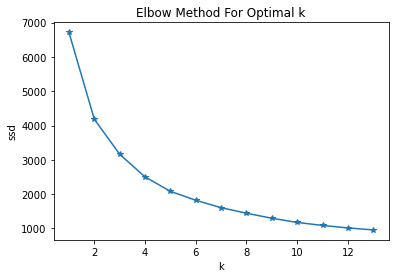

In [26]:
# Plot sum of squared distances / elbow method
plt.figure(figsize=(6,4))
plt.plot(K, ssd, '-*')
plt.xlabel('k')
plt.ylabel('ssd')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see in here that we need to choose the K which is "6"

Now we have to do analyze the segmentation

### K=6

In [83]:
#Segmentation k=6
kmeans = KMeans(n_clusters=6)
pred = kmeans.fit_predict(data_std)
rfm_2['Segmentation'] = pred

Text(0, 0.5, 'Frequency')

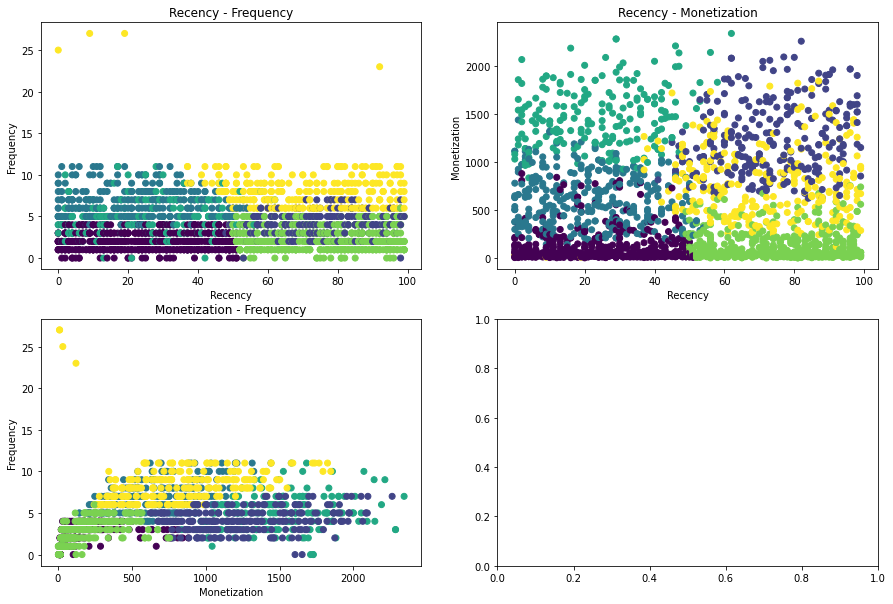

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(10)


ax[0,0].scatter(rfm_2['Recency'], rfm_2['Frequency'], c=rfm_2['Segmentation'])
ax[0,0].set_title('Recency - Frequency')
ax[0,0].set_xlabel('Recency')
ax[0,0].set_ylabel('Frequency')

ax[0,1].scatter(rfm_2['Recency'], rfm_2['Monetization'], c=rfm_2['Segmentation'])
ax[0,1].set_title('Recency - Monetization')
ax[0,1].set_xlabel('Recency')
ax[0,1].set_ylabel('Monetization')

ax[1,0].scatter(rfm_2['Monetization'], rfm_2['Frequency'], c=rfm_2['Segmentation'])
ax[1,0].set_title('Monetization - Frequency')
ax[1,0].set_xlabel('Monetization')
ax[1,0].set_ylabel('Frequency')

We see in here that the connection between 3 variables R,F,M with K=6 is varies. To support our takes for K=6, we need to see the aggregation for those 6 segments

In [86]:
rfm_2.groupby('Segmentation').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetization':'mean'})

,Recency,Frequency,Monetization
Segmentation,,,
0,25.242268,2.020619,105.773196
1,73.340580,4.148551,1244.192029
2,22.169811,6.720126,618.918239
3,23.908654,4.899038,1466.447115
4,75.416520,2.330404,121.608084
5,70.163763,8.177700,772.714286


When we are looking at here, we see that the threshold is varies for each R,F,M. If wee see on data above, it likely to be hard for us to classify what is the behavior of users

i.e. we want MVP customers which with the lowest Recency, highest Frequency, and highest Monetization in average. When we are looking at the data above, we can't see which segment that fit with MVP customers criteria

so lets take a look if we change the K into 4

### K=4

In [87]:
#Segmentation
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit_predict(data_std)
rfm_2['Segmentation'] = pred

Text(0, 0.5, 'Frequency')

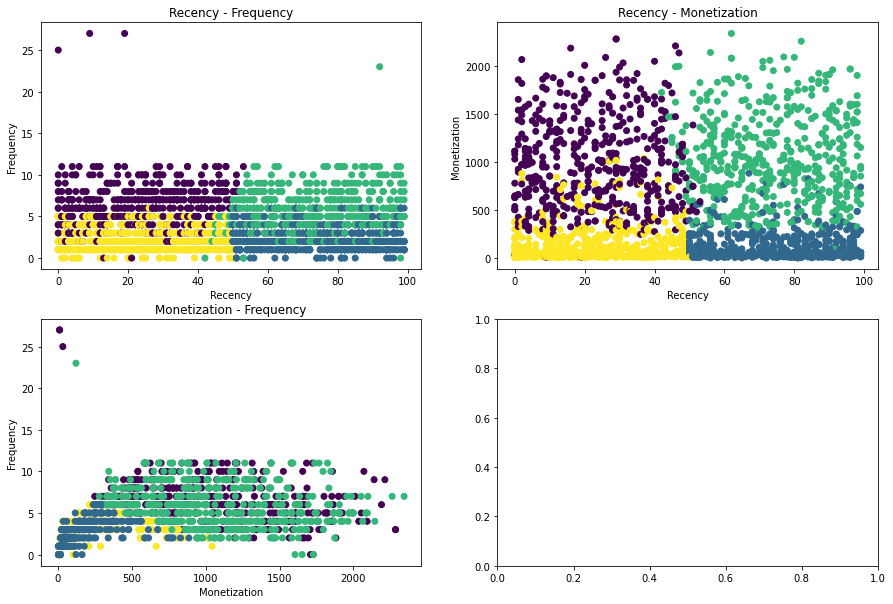

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(10)


ax[0,0].scatter(rfm_2['Recency'], rfm_2['Frequency'], c=rfm_2['Segmentation'])
ax[0,0].set_title('Recency - Frequency')
ax[0,0].set_xlabel('Recency')
ax[0,0].set_ylabel('Frequency')

ax[0,1].scatter(rfm_2['Recency'], rfm_2['Monetization'], c=rfm_2['Segmentation'])
ax[0,1].set_title('Recency - Monetization')
ax[0,1].set_xlabel('Recency')
ax[0,1].set_ylabel('Monetization')

ax[1,0].scatter(rfm_2['Monetization'], rfm_2['Frequency'], c=rfm_2['Segmentation'])
ax[1,0].set_title('Monetization - Frequency')
ax[1,0].set_xlabel('Monetization')
ax[1,0].set_ylabel('Frequency')

In [89]:
rfm_2.groupby('Segmentation').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetization':'mean'})

,Recency,Frequency,Monetization
Segmentation,,,
0,22.979210,6.569647,995.852391
1,74.947279,2.357143,122.986395
2,72.766667,5.862963,1042.011111
3,24.705230,2.278922,132.727417


When we are seeing at the data above, we can conclude that if we are using K=4, from data distribution (scatterplot above) is well-distributed, we can clearly distinguish parts for each segment.

Also from the aggregation table above, we can easily make classification since the segment number is lower and if we are looking at the example above (for MVP customer), we required lowest Recency, highest Frequency, and highest Monetization which we can conclude the criteria is fit for particular segment (segment 1).

Therefore we are going to use K=4 to make 4 segmentation

From what we are seeing here there are 4 segmentation and here is the details about its segmentation:

0. **Recently Active not Frequent**: Users that recently active but not that much frequent visiting the web
1. **MVP Users**: Start users who is our potential segment
2. **Low Value Users**: Users which have low potential
3. **Churned Users**: Potential users that have been lost for a long time

In [90]:
rfm_2['Segmentation'].value_counts()

3    631
1    588
2    540
0    481
Name: Segmentation, dtype: int64

In [91]:
rfm_2['Class'] = rfm_2['Segmentation'].replace({0:'Recently Active Not Frequent',
                                               1:'MVP Users',
                                               2:'Low Value Users',
                                               3:'Churned Users'})

In [92]:
rfm_2

,ID,Recency,Frequency,Monetization,Segmentation,Class
0,1826,0,4,783,0,Recently Active Not Frequent
1,1,0,7,540,0,Recently Active Not Frequent
2,10476,0,3,219,3,Churned Users
3,1386,0,1,11,3,Churned Users
4,5371,0,3,57,3,Churned Users
...,...,...,...,...,...,...
2235,10142,99,5,563,2,Low Value Users
2236,5263,99,1,31,1,MVP Users
2237,22,99,6,290,1,MVP Users
2238,528,99,5,1155,2,Low Value Users


### Conclusion

As we see from both approaches (manual distribution & kmeans classification), we can assume that both of its approach is applicable for us to do classification. But here the things that distinguish between those two approaches:

1. 1st approach (manual) is more into pattern reading and setting the threshold. Also we can easily pick what is the right number of classification best on the threshold we got. Rather in 2nd approach, the number of classification based on K-mean clustering (elbowing) so the best number of classification is based on the data we got and its algorithm

2. We need to double-triple check by doing 1st approach (manual) for its distribution after we are classifying them, by looking at their segment classification, whether is it distributed well or it made a random distribution. Different with the 2nd approach, we know using K-means is automatically classified so we can rely on the distribution (as long as we pick the right K)

3. We have to check its variance for each R, F, M whether its distributed well or not, if not we have to scale the data first to reduce its variance and make it more distributed

Also here is the things that I want elaborate more so with this RFM analysis, it can be more useful to other stakeholder:
- We can incorporate this RFM segmentation with customer profile dataset that we got above (income, education, age) so we can more accurate whether we want to targeted particular segment with particular action item (I have created it in the dashboard link below)
- We should also combine this data with market size and consumer journey, so we can know which journey we have to tackle and is it worth it or not by looking at its market size

Here is the link to the dashboard from this dataset analysis:
https://public.tableau.com/views/MarketingProject2_16499289672140/RFMAnalysis?:language=en-US&:display_count=n&:origin=viz_share_link

From this dashboard you can analyze (from this dataset above):
- User profile for this campaign
- Campaign success rate
- RFM profile segmentation
- RFM segment campaign attendance
- RFM segment market size
- Combination of RFM segment and user profile